In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

seed = 10
np.random.seed(seed)

In [2]:
import scipy
def plot_batch_effect_cellanova(adata, cell_type_key, batch_key, condition_key, dataset_name):
    adata.raw = None
    print(dataset_name,"adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"] = batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print(dataset_name,"batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print(dataset_name,"batch_all_with_condition", np.unique(batch_all_with_condition))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")
    print(dataset_name,"Finish preprocessing")

    if isinstance(adata.X, scipy.sparse.spmatrix):
        adata.X = adata.X.toarray()
    
    print(dataset_name,"Original:",adata.X[:10,:10])
    print(dataset_name,"Denoised:",adata.layers['denoised'][:10,:10])
    
    integrated = ad.AnnData(adata.layers['denoised']-adata.X, dtype=np.float32)
    integrated.obs = adata.obs.copy()
    integrated.var_names = adata.var_names

    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(integrated, color=colori, ncols=1)

    print(dataset_name, "Within each unique condition, plot batch effect")
    unique_conditions = np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print(dataset_name, "Now evaluating", conditioni, "denoised expression")
        integratedi = integrated[integrated.obs[condition_key] == conditioni]
        for colori in [cell_type_key] + batch_key:
            sc.pl.umap(integratedi, color=colori, ncols=1)
        print("-" * 20)

# Type 1 diabetes

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148073

t1d adata preprocessing...
t1d batch_all ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']
t1d batch_all_with_condition ['HPAP019__AAB' 'HPAP020__T1D' 'HPAP021__T1D' 'HPAP022__Control'
 'HPAP023__T1D' 'HPAP024__AAB' 'HPAP026__Control' 'HPAP028__T1D'
 'HPAP029__AAB' 'HPAP032__T1D' 'HPAP034__Control' 'HPAP035__Control'
 'HPAP036__Control' 'HPAP037__Control' 'HPAP038__AAB' 'HPAP039__Control'
 'HPAP040__Control' 'HPAP042__Control' 'HPAP043__AAB' 'HPAP044__Control'
 'HPAP045__AAB' 'HPAP047__Control' 'HPAP049__AAB' 'HPAP050__AAB']
t1d Finish preprocessing
t1d Original: [[-0.09964925 -0.07632102 -0.24642734 -0.15308443 -0.32198244 -0.173297
  -0.04214706 -0.08946147 -0.7452111  -0.3470034 ]
 [-0.09964925 -0.07632102 -0.24642734 -0.15308443 -0.32198244 -0.173297
  -0.04214706 -0.08946147 -0.25538957 -0

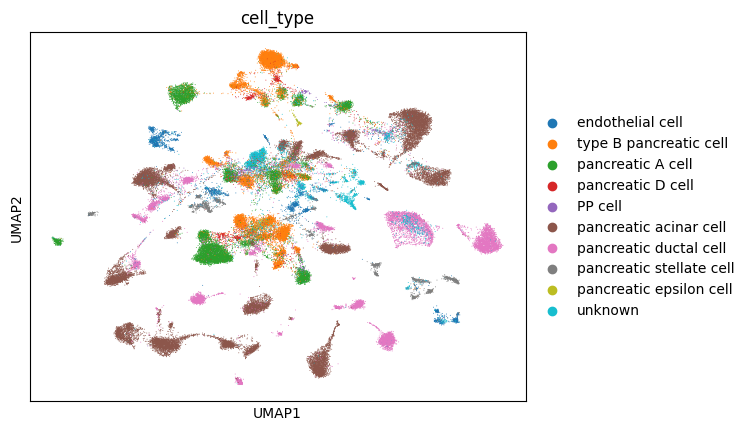

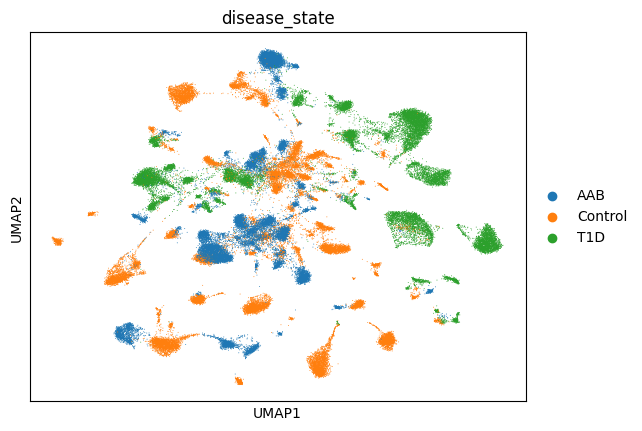

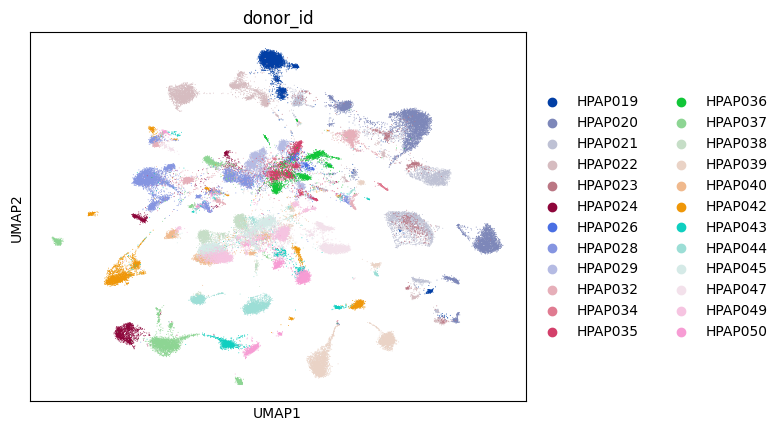

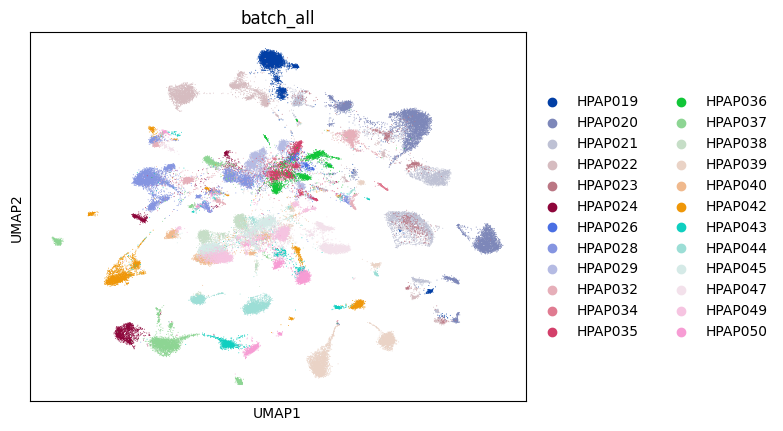

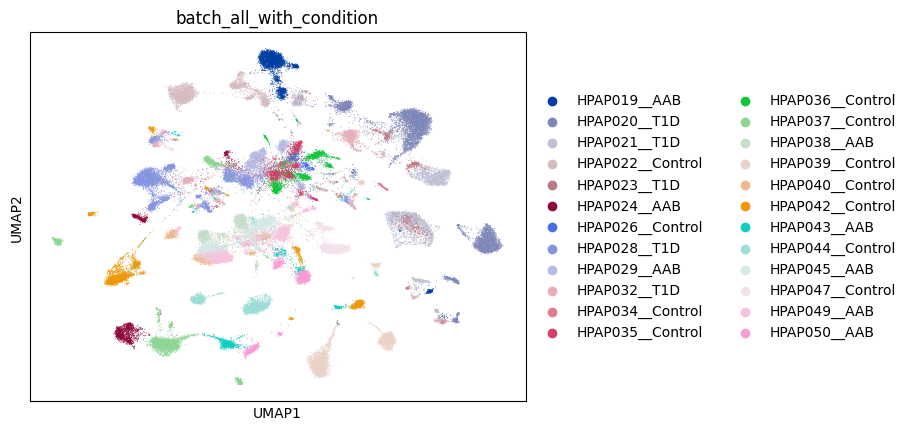

t1d Within each unique condition, plot batch effect
t1d Now evaluating AAB denoised expression


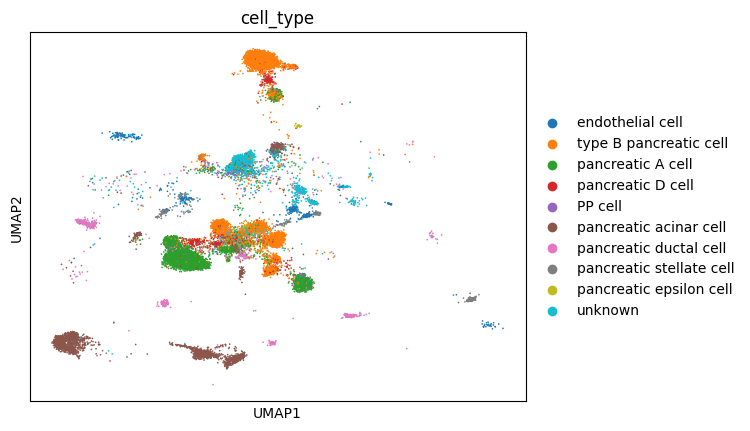

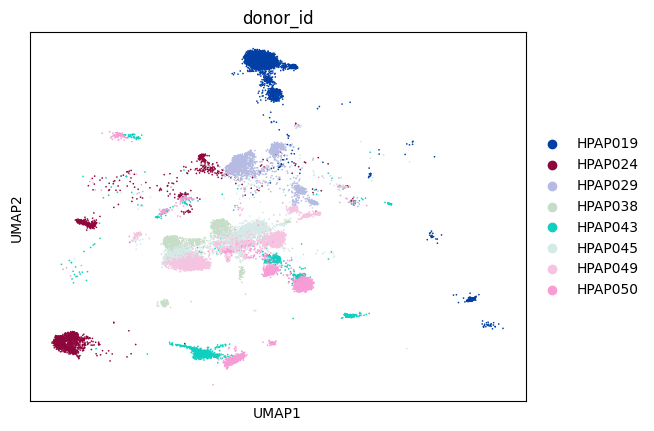

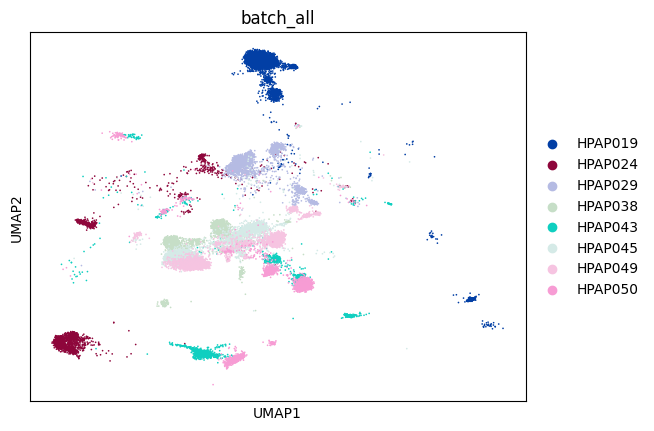

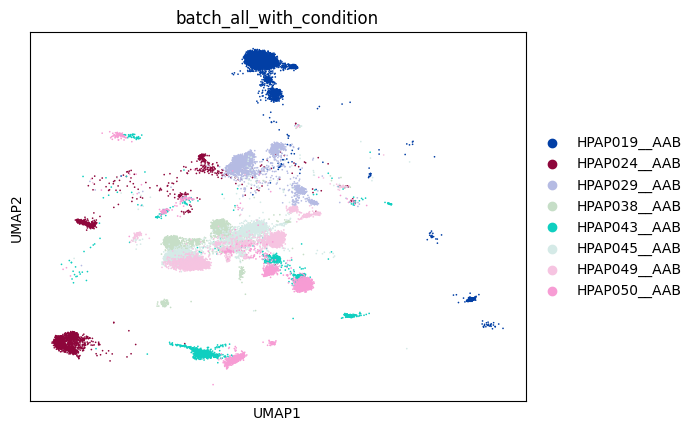

--------------------
t1d Now evaluating Control denoised expression


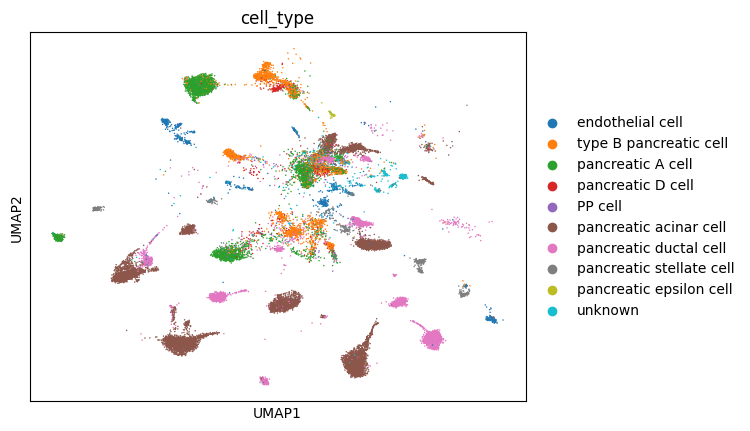

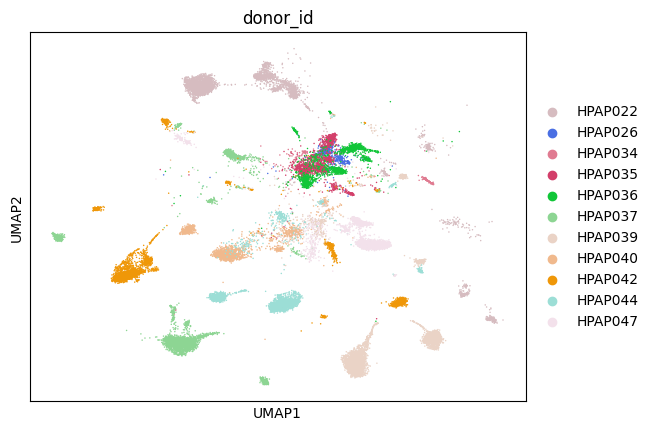

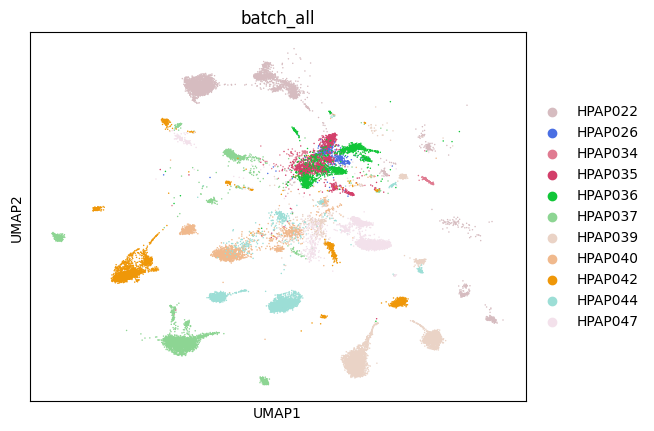

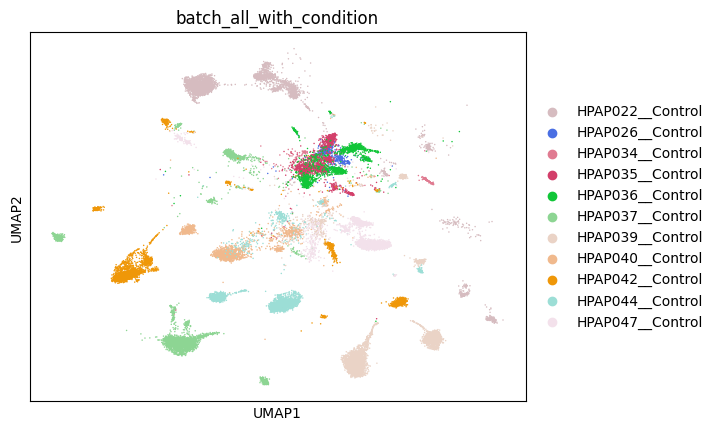

--------------------
t1d Now evaluating T1D denoised expression


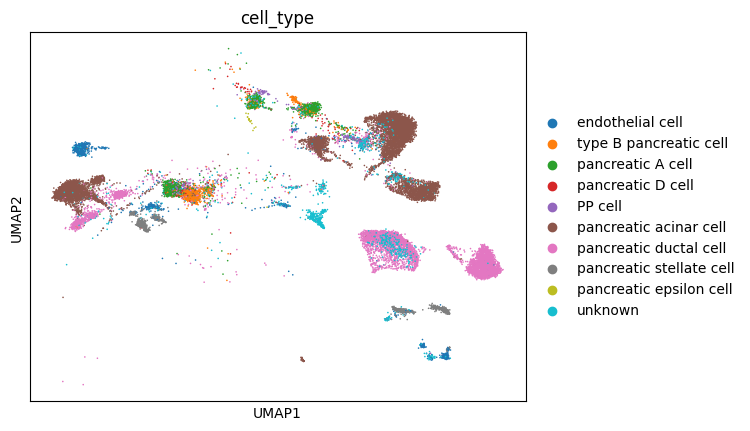

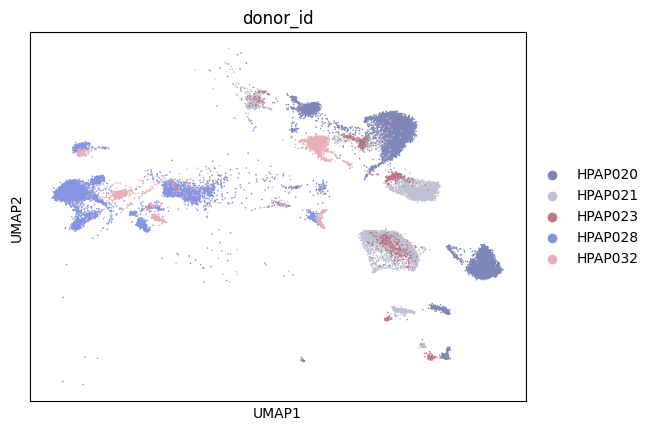

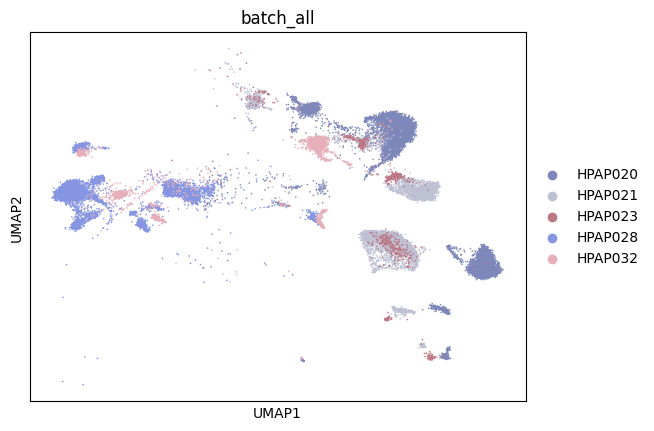

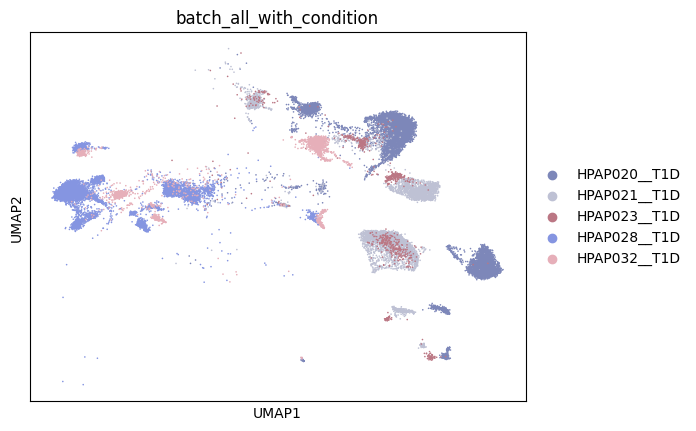

--------------------


In [3]:
adata=sc.read_h5ad("./cellanova/t1d_results.h5ad")
plot_batch_effect_cellanova(adata=adata,cell_type_key="cell_type",batch_key="donor_id",
                   condition_key="disease_state",dataset_name="t1d")

# Human kidney multiomics atlas

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE211785

In [ ]:
adata=sc.read_h5ad("./cellanova/kidney_results.h5ad")
plot_batch_effect_cellanova(adata=adata,cell_type_key='Cluster_Idents',batch_key=['sample','tech'], condition_key="Status",dataset_name="kidney")

# Mouse radiation experiment dataset

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE280883

In [ ]:
adata=sc.read_h5ad("./cellanova/mouse_results.h5ad")
adata.obs['orig_ident']=adata.obs['orig.ident'].copy()
plot_batch_effect_cellanova(adata=adata,cell_type_key='compartment',batch_key=['orig_ident',"replicate","source"],
                   condition_key="sample",dataset_name="mouse")

# SEA-AD dataset

https://cellxgene.cziscience.com/collections/1ca90a2d-2943-483d-b678-b809bf464c30

In [ ]:
adata=sc.read_h5ad("./cellanova/AD_results.h5ad")
adata.raw=None
print(adata.obs_names)
plot_batch_effect_cellanova(adata=adata,cell_type_key='Subclass',batch_key=['donor_id'],
                   condition_key="disease",dataset_name="AD")